# Importing the required dependencies

In [408]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
torch.manual_seed(1337)

from matplotlib import pyplot as plt

# Device configuration

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    print('GPU:', torch.cuda.get_device_properties(0).name)
else:
    print("CPU")

# Loading dataset

In [381]:
with open("./tinyShakesphere.txt", "r", encoding="utf-8") as file:
    text = file.read()

# Creating Vocabulary

In [382]:
chars = sorted(set(text))
vocab_size = len(chars) 
print(''.join(chars))
print(len(chars))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [383]:
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Encoding Dataset and Train, Test Split

In [384]:
encoded_text = torch.tensor(encode(text), dtype=torch.long)

In [385]:
encoded_text

tensor([18, 47, 56,  ..., 52, 45,  8])

In [386]:
train_size = 0.9

train_data = encoded_text[:int(train_size*len(encoded_text))]
val_data = encoded_text[int(train_size*len(encoded_text)):]

# Modeling

In [387]:
block_size = 8
batch_size = 4
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

In [388]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, device='cpu'):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
        self.device = device
    
    def forward(self, idx, targets=None):
        idx = idx
        if targets is not None:
            targets = targets
        logits = self.token_embedding_table(idx) # (B,T,C) B-> 4(batch_size),T-> 8(block_size),C-> 65(vocab_size)
        if targets is None:
            loss = None
        else: 
            B, T, C =  logits.shape
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:,-1,:] # (B, C)
            probs = F.softmax(logits, dim=1) # (B, C)
            idx_next = torch.multinomial(probs,num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
 

# Model init and sampling before training 

In [402]:
bigram = BigramLanguageModel(vocab_size).to(device)

In [403]:
print(decode(bigram.generate(torch.tensor([[0]], dtype=torch.long,device=device), max_new_tokens=100)[0].tolist()))


I'ZI!!TawjYD$NaZ
u;Ihsj
:JstoUYr3,K,'diPlT
RWBTQQslSdlXkihT$dloN-.o;nt
'ZTM;sC$-TiwcX-eyXtR,Uu!!-sCW


# Optimizer init and training the model

In [404]:
optimizer = optim.AdamW(bigram.parameters(), lr=1e-3)

In [405]:
@torch.no_grad()
def estimate_loss(model, eval_iters):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x,y = get_batch(split)
            logits, loss = model(x,y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [406]:
train_loss = []
val_loss = []
step = []

In [414]:
batch_size = 32
eval_iters = 200
for steps in range(5000):
    if steps % eval_iters == 0:
        losses = estimate_loss(bigram, eval_iters)
        print(f'step {steps}: train loss {losses['train']:.4f}, test loss {losses['val']:.4f}')
        train_loss.append(losses['train'])
        val_loss.append(losses['val'])
        step.append(step[-1] + eval_iters if step else eval_iters)
    xb, yb = get_batch(train_data)
    logits, loss = bigram(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

step 0: train loss 2.6257, test loss 2.4354


step 200: train loss 2.6037, test loss 2.4381
step 400: train loss 2.6116, test loss 2.4269
step 600: train loss 2.6084, test loss 2.4258
step 800: train loss 2.6042, test loss 2.4184
step 1000: train loss 2.5983, test loss 2.4103
step 1200: train loss 2.5982, test loss 2.4064
step 1400: train loss 2.5913, test loss 2.4207
step 1600: train loss 2.6033, test loss 2.4102
step 1800: train loss 2.6056, test loss 2.4074
step 2000: train loss 2.5884, test loss 2.4012
step 2200: train loss 2.5806, test loss 2.3927
step 2400: train loss 2.5983, test loss 2.3948
step 2600: train loss 2.5946, test loss 2.3961
step 2800: train loss 2.5965, test loss 2.3896
step 3000: train loss 2.5986, test loss 2.3910
step 3200: train loss 2.5927, test loss 2.3866
step 3400: train loss 2.5908, test loss 2.3881
step 3600: train loss 2.6018, test loss 2.3842
step 3800: train loss 2.5966, test loss 2.3948
step 4000: train loss 2.6077, test loss 2.3870
step 4200: train loss 2.5963, test loss 2.3817
step 4400: train 

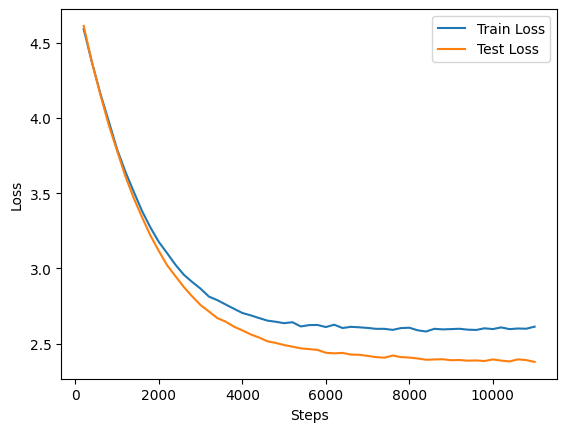

In [415]:
plt.plot(step, train_loss, label='Train Loss')
plt.plot(step, val_loss, label='Test Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Sampling from the trained model

In [417]:
print(decode(bigram.generate(torch.tensor([[0]], dtype=torch.long,device=device), max_new_tokens=1000)[0].tolist()))


Whwice my.

HDETarom orou waowhthetof isth bot mil ndill, ath iree s, hein lat Heridrovets, and Win nghir.
Pranousel lind me l.
HA:
THonchiry:
ARO: aisspllw y.
HI BI's noroopetelaves
MIO:
PERThe te akleo Windo whth eribyo wie m dourive ce hidend t so KANDENTre

ANZAndnterupt f s ar iris! m:

Thiny aleronth, af PENTh KASo myoungoube!
Kated isar adat Wices ghesthidin cour ay aney IO:



IOfr y ce.
O:
TETher, bemary.
Yor 'sou wne?
Isora anghy t-e?
ANTORUCowien.
Wand s st su in s th llugibome.
IOSuco ffepyotssthecas l.
TAn.
Mourethapeintherse ed PTAPRTHalvet:
HIApasst toros cok hedin tie st u d he te feRUCates:
Whit Clo ghasundisthou idu IONo, moxchar.

Anthataker aghercobun wsam s s withoumas mond t s wlld IRO:

I andorsed
Fourd?
TIO:


MIO:
&Xno nded Cattey
Kavethatou tised tho nofen e sutan wiporthare whanothavittheruglepe Bllellke, oung h O, t pan, ce wat d tive wout ir f; u;

ANIONSioueee rtano iru fo.

Find fet HInk;
CUCad n tck in, d cer t ftanofallon bay ho shergallen, meswe minds